In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [2]:
tickers_smi = [
    'NESN.SW',  # Nestlé S.A.
    'ROG.SW',   # Roche Holding AG
    'NOVN.SW',  # Novartis AG
    'CFR.SW',   # Compagnie Financière Richemont SA
    'UBSG.SW',  # UBS Group AG
    'ABBN.SW',  # ABB Ltd
    'ZURN.SW',  # Zurich Insurance Group AG
    'HOLN.SW',  # Holcim Ltd
    'LONN.SW',  # Lonza Group AG
    'ALC.SW',   # Alcon Inc.
    'SREN.SW',  # Swiss Re AG
    'SIKA.SW',  # Sika AG
    'GIVN.SW',  # Givaudan SA
    'PGHN.SW',  # Partners Group Holding AG
    'KNIN.SW',  # Kuehne + Nagel International AG
    'SCMN.SW',  # Swisscom AG
    'SLHN.SW',  # Swiss Life Holding AG
    'GEBN.SW',  # Geberit AG
    'SOON.SW',  # Sonova Holding AG
    'LOGN.SW'   # Logitech International S.A.
]

In [3]:
end_date = datetime.today() - timedelta(days = 1)
print(end_date)

2025-02-26 23:00:48.794279


In [61]:
start_date = end_date - timedelta(days= 5*365)
print(start_date)

2020-02-28 23:00:48.794279


In [62]:
adj_close_df = pd.DataFrame()

In [63]:
for ticker in tickers_smi:
    data = yf.download(ticker, start = start_date, end = end_date, auto_adjust=False)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [64]:
print(adj_close_df)

              NESN.SW      ROG.SW     NOVN.SW      CFR.SW    UBSG.SW  \
Date                                                                   
2020-02-28  86.649315  262.687012   62.861355   58.969711   8.199768   
2020-03-02  88.130722  266.927979   63.441612   58.049992   8.134015   
2020-03-03  90.655258  272.186768   65.196800   58.735268   8.122411   
2020-03-04  92.934357  280.668823   66.523720   59.402512   8.110807   
2020-03-05  92.461006  280.159851   66.017075   58.031963   7.882607   
...               ...         ...         ...         ...        ...   
2025-02-20  82.339996  295.299988   96.660004  180.100006  30.070000   
2025-02-21  85.099998  298.399994   98.150002  180.350006  30.320000   
2025-02-24  87.779999  298.100006   98.410004  178.100006  30.110001   
2025-02-25  89.019997  299.299988  100.720001  179.300003  30.070000   
2025-02-26  87.599998  299.899994   97.029999  183.800003  30.719999   

              ABBN.SW     ZURN.SW    HOLN.SW     LONN.SW     AL

Calculation of Lognormal returns for each tickers

In [65]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [66]:
log_returns = log_returns.dropna()

Covariance matrix. We multiply by 252 in order to annualise the value

In [67]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          NESN.SW    ROG.SW   NOVN.SW    CFR.SW   UBSG.SW   ABBN.SW   ZURN.SW  \
NESN.SW  0.029522  0.016791  0.016801  0.017124  0.014476  0.014012  0.014902   
ROG.SW   0.016791  0.043265  0.021054  0.013671  0.016081  0.014941  0.016713   
NOVN.SW  0.016801  0.021054  0.035012  0.016463  0.019958  0.019456  0.020545   
CFR.SW   0.017124  0.013671  0.016463  0.124084  0.060364  0.049174  0.033553   
UBSG.SW  0.014476  0.016081  0.019958  0.060364  0.103510  0.054811  0.045556   
ABBN.SW  0.014012  0.014941  0.019456  0.049174  0.054811  0.067782  0.034314   
ZURN.SW  0.014902  0.016713  0.020545  0.033553  0.045556  0.034314  0.048531   
HOLN.SW  0.013684  0.012952  0.019423  0.046197  0.056274  0.047356  0.038138   
LONN.SW  0.017572  0.025670  0.018530  0.035838  0.027815  0.030324  0.018174   
ALC.SW   0.016935  0.017764  0.021142  0.040766  0.036008  0.035060  0.026126   
SREN.SW  0.011434  0.013914  0.019159  0.042686  0.053660  0.039224  0.046818   
SIKA.SW  0.018749  0.019219 

Calculate the PF STD DEV

In [68]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Calulate Expected Returns

Assumption: We base expected return on past returns. We assume that the future returns will be the average of past returns.

In [69]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

Calculate the Sharpe Ratio

In [70]:
def sharpe_ratio(weights, log_returns_, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

Risk free rate

In [71]:
from fredapi import Fred

# Replace with your actual FRED API Key
fred = Fred(api_key='3ed72ba7792bc5b11006b39d80be00dd')

# Get the latest 10-year Treasury rate
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

# The value is already a float, no need for iloc
risk_free_rate = ten_year_treasury_rate.iloc[-1]

print(risk_free_rate)

0.0463


Define the function to minimize (negative Sharpe Ratio). In case of the scipy.optimize.minimize() function, there is no direct method to find the maximum value of a function

In [72]:

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)


Set the Contraints. Bounds--> 0-0.5 are the maximum weights. No long and we cannot have over 50% of our PF in one security.

In [73]:
constraints = {'type': 'eq', 'fun' : lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers_smi))]

Set the inital weights

In [74]:

initial_weights = np.array([1/len(tickers_smi)]*len(tickers_smi))
print(initial_weights)

[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]


Now we are going to optimise the weights to maximise the Sharpe Ratio

In [75]:
optimised_results = minimize(neg_sharpe_ratio, initial_weights, args = (log_returns, cov_matrix, risk_free_rate), method = 'SLSQP', constraints = constraints, bounds = bounds)
print(optimised_results)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7625494778531315
       x: [ 8.071e-17  0.000e+00 ...  0.000e+00  1.657e-01]
     nit: 9
     jac: [ 1.802e-01  9.622e-02 ...  2.392e-01 -1.896e-01]
    nfev: 189
    njev: 9


Get the Optimal Weights

In [76]:
optimal_weights = optimised_results.x

Display analytics of the optimal PF

In [77]:
print("Optimal Weights:")
print()
for ticker, weight in zip(tickers_smi, optimal_weights):
    print(f"{ticker}: {weight: .4f}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return: .4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility: .4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio: .4f}")

Optimal Weights:

NESN.SW:  0.0000
ROG.SW:  0.0000
NOVN.SW:  0.0000
CFR.SW:  0.0848
UBSG.SW:  0.3673
ABBN.SW:  0.3415
ZURN.SW:  0.0000
HOLN.SW:  0.0407
LONN.SW:  0.0000
ALC.SW:  0.0000
SREN.SW:  0.0000
SIKA.SW:  0.0000
GIVN.SW:  0.0000
PGHN.SW:  0.0000
KNIN.SW:  0.0000
SCMN.SW:  0.0000
SLHN.SW:  0.0000
GEBN.SW:  0.0000
SOON.SW:  0.0000
LOGN.SW:  0.1657

Expected Annual Return:  0.2325
Expected Volatility:  0.2441
Sharpe Ratio:  0.7625


Display the final portfolio in a plot

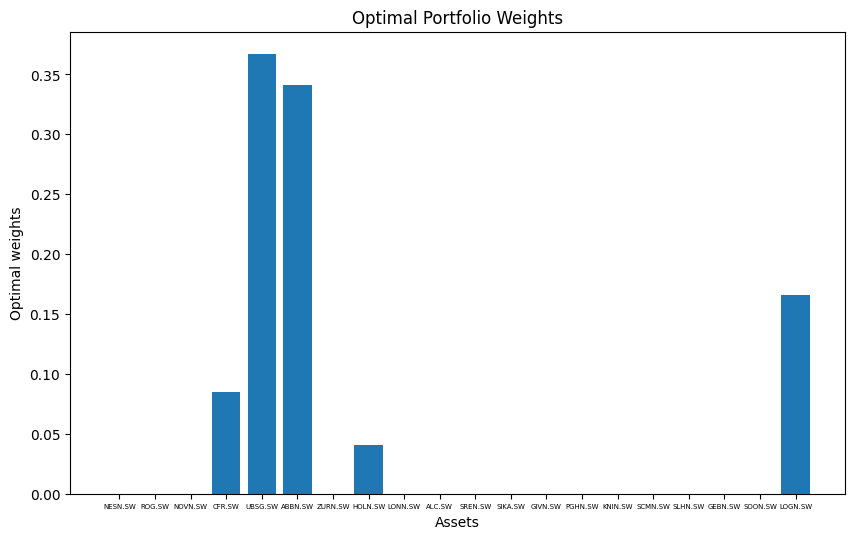

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.bar(tickers_smi, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal weights')
plt.title('Optimal Portfolio Weights')

plt.xticks(size = 5)

plt.show()